## Machine Learning Engineer Nanodegree

# Capstone Project

## Google Analytics Customer Revenue Prediction

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

### Datasets
- train.csv - the training set 
- test.csv - the test set 
- sampleSubmission.csv - a sample submission file in the correct format. Contains all fullVisitorIds in test.csv.

#### Data Fields
- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- sessionId - A unique identifier for this visit to the store.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).

#### Removed Data Fields
Some fields were censored to remove target leakage. The major censored fields are listed below.

- hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
- totals - Multiple sub-columns were removed from the totals field.

## 1. Loading Data and Libraries

In [2]:
# Import libraries necessary for this project
import os
import json
import csv
import numpy as np
import pandas as pd
import datetime
import math
import matplotlib.mlab as mlab
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import tensorflow as tf
# from tensorflow import keras

# import shap
# import eli5
# from eli5.sklearn import PermutationImportance

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from keras import optimizers, activations, models
from keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler, LambdaCallback, Callback


%matplotlib inline

from sklearn import model_selection, preprocessing, metrics

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

Using TensorFlow backend.


Flattening the JSON blobs

In [ ]:
def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df


In [ ]:
%%time
train_df = load_df()

In [ ]:
%%time
test_df = load_df("/data/test.csv")

In [ ]:
train_df.columns.difference(test_df.columns)

We can see now that:

- `train.csv` has 903,653 rows and 55 columns 
- `test.csv` has 804,684 rows and 53 columns

The columns not included in test.csv are `totals.transactionRevenue` as expected and `trafficSource.campaignCode`

## 2. Data Exploration

Now the dataset has been flattened, it is easy to refer to any part of the dataframe and explore various features. Firstly, let's look at the target variable totals.transactionRevenue for each user.

In [ ]:
train_df.head()

In [ ]:
test_df.head()

There also appear to be many columns with constant information in, such as `NaN` or `not available in demo dataset`. If entire columns contain the same information like these then they will likely not be of use. The code below tests for columns that only have 1 unique value.

In [ ]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

In [ ]:
train_df = train_df.drop(const_cols, axis=1)
train_df.shape

In [ ]:
test_df = test_df.drop(const_cols, axis=1)
test_df.shape

In [ ]:
train_df.to_csv("data/newTrain.csv")

In [ ]:
test_df.to_csv("data/newTest.csv")

The columns that contain the null or useless values have been removed from the datasets, which now have 19 fewer columns. I have also saved the new dataframes to new csv files as they will be easier to acquire and work from later.

In [2]:
nTrain_df = pd.read_csv("data/newTrain.csv", 
                 dtype={'fullVisitorId': 'str',
                       'campaignCode': 'str'})
print (nTrain_df.shape)
nTrain_df.head()

(903653, 37)


,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,city,continent,country,metro,networkDomain,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,adContent,adwordsClickInfo.adNetworkType,adwordsClickInfo.gclId,adwordsClickInfo.isVideoAd,adwordsClickInfo.page,adwordsClickInfo.slot,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [3]:
nTest_df = pd.read_csv("data/newTest.csv", 
             dtype={'fullVisitorId': 'str'})
print (nTest_df.shape)
nTest_df.head()

(804684, 35)


,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,city,continent,country,metro,networkDomain,region,subContinent,bounces,hits,newVisits,pageviews,adContent,adwordsClickInfo.adNetworkType,adwordsClickInfo.gclId,adwordsClickInfo.isVideoAd,adwordsClickInfo.page,adwordsClickInfo.slot,campaign,isTrueDirect,keyword,medium,referralPath,source
0,0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,1508151024,2,1508151024,Chrome,desktop,False,Macintosh,(not set),Asia,Singapore,(not set),myrepublic.com.sg,(not set),Southeast Asia,NaN,4,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,1508175522,1,1508175522,Chrome,desktop,False,Windows,Zaragoza,Europe,Spain,(not set),rima-tde.net,Aragon,Southern Europe,NaN,5,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,1508143220,1,1508143220,Chrome,desktop,False,Macintosh,not available in demo dataset,Europe,France,not available in demo dataset,sfr.net,not available in demo dataset,Western Europe,NaN,7,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,1508193530,1,1508193530,Safari,mobile,True,iOS,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,8,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,1508217442,1,1508217442,Safari,desktop,False,Macintosh,San Jose,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,9,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


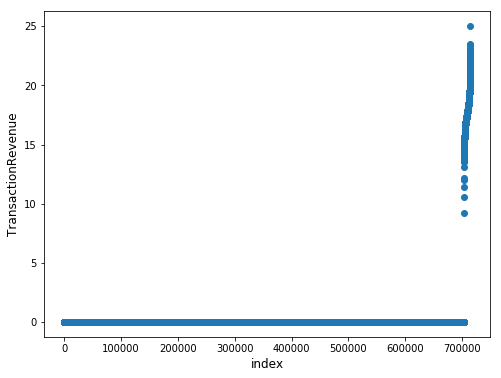

In [4]:
nTrain_df["transactionRevenue"].fillna(0, inplace=True)
nTrain_df["transactionRevenue"] = nTrain_df["transactionRevenue"].astype('float')
gdf = nTrain_df.groupby("fullVisitorId")["transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

It is clear to see the revenue comes from a select few of customers, as stated by the 80/20 rule

In [12]:
num_buyers = (gdf["transactionRevenue"]>0).sum()
print (num_buyers)
print("Number of unique customers: ",gdf.shape[0]," with non-zero revenue : ", num_buyers, "and the ratio is : ", (num_buyers / gdf.shape[0])*100)
print ("The ratio is much lower than 80/20, only 1.3% of visitors have spent money")


9996
Number of unique customers:  714167  with non-zero revenue :  9996 and the ratio is :  1.39967262559
The ratio is much lower than 80/20, only 1.3% of visitors have spent money


In [21]:
minimum = np.log1p(np.min(gdf["transactionRevenue"]))
maximum = np.log1p(np.max(gdf["transactionRevenue"]))
mean= np.log1p(np.mean(gdf["transactionRevenue"]))
std= np.log1p(np.std(gdf["transactionRevenue"]))

# Show the calculated statistics
print("Statistics for total revenue per fullVisitorID:\n")
print("Minimum: ${}".format(minimum))
print("Maximum: ${}".format(maximum))
print("Mean: ${}".format(mean))
print("Standard deviation: ${}".format(std))

Statistics for total revenue per fullVisitorID:

Minimum: $0.0
Maximum: $25.06854329172392
Mean: $14.583978147217332
Standard deviation: $18.501230286750427


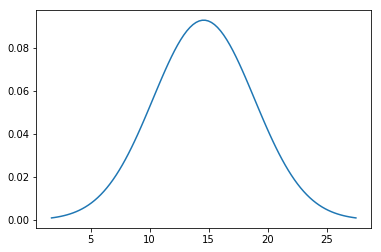

In [22]:
sigma = math.sqrt(std)
x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mean, sigma))
plt.show()

This is a simple distribution of what the total revenue is expected to be amongst those visitors that spend money.

In [ ]:
def horizontal_bar_chart(y1, x1, y2, x2, y3, x3, data):
    f, axes = plt.subplots(1,3,figsize=(18, 6))
    
    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot(y=y1, x=x1, data=data,
            label="Total", ax=axes[0])
    
    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot(y=y2, x=x2, data=data,
            label="Total", ax=axes[1])
    
    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot(y=y3, x=x3, data=data,
            label="Total", ax=axes[2])
    
    plt.tight_layout()

In [ ]:
data = nTrain_df.groupby("browser")["transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("browser", "count", "browser", "count of transactions", "browser", "mean transaction", data.head(10))


In [ ]:
data = nTrain_df.groupby("deviceCategory")["transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("deviceCategory", "count", "deviceCategory", "count of transactions", "deviceCategory", "mean transaction", data)

In [ ]:
data = nTrain_df.groupby("operatingSystem")["transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("operatingSystem", "count", "operatingSystem", "count of transactions", "operatingSystem", "mean transaction", data)

In [ ]:
data = nTrain_df.groupby("continent")["transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("continent", "count", "continent", "count of transactions", "continent", "mean transaction", data)

In [ ]:
data = nTrain_df.groupby("subContinent")["transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("subContinent", "count", "subContinent", "count of transactions", "subContinent", "mean transaction", data)

In [ ]:
data = nTrain_df.groupby("country")["transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("country", "count", "country", "count of transactions", "country", "mean transaction", data.head(10))


In [ ]:
data = nTrain_df.groupby("region")["transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("region", "count", "region", "count of transactions", "region", "mean transaction", data.head(10))


In [ ]:
data = nTrain_df.groupby("source")["transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("source", "count", "source", "count of transactions", "source", "mean transaction", data.head(10))


#### Summary of bar charts

- Google Chrome is a clear preference of visitors and buyers. Firefox users spend more on average
- The desktop version of the site is used much more than mobile
- Windows is the most common OS for visitors, yet Mac users are much more likely to purchase an item
- The Americas host the greater number of visitors and buyers, in particular the United States with states such as California, New York and Washington having higher numbers of buyers
- African buyers spend more on each transaction than any other buyers
- Google is the clear leader for traffic source but most transactions appear to be coming from within the googleplex.com domain, implying that many staff at Google are purchasing from the store

In [5]:
nTrain_df['datetime'] = nTrain_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
nTest_df['datetime'] = nTest_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))


In [38]:
def line_plot( data):
    f, axes = plt.subplots(figsize=(18, 6))

    sns.set(style="white")
    sns.lineplot( data=data, palette="tab10", linewidth=2.5)
    
    plt.tight_layout()

AttributeError: module 'seaborn' has no attribute 'lineplot'

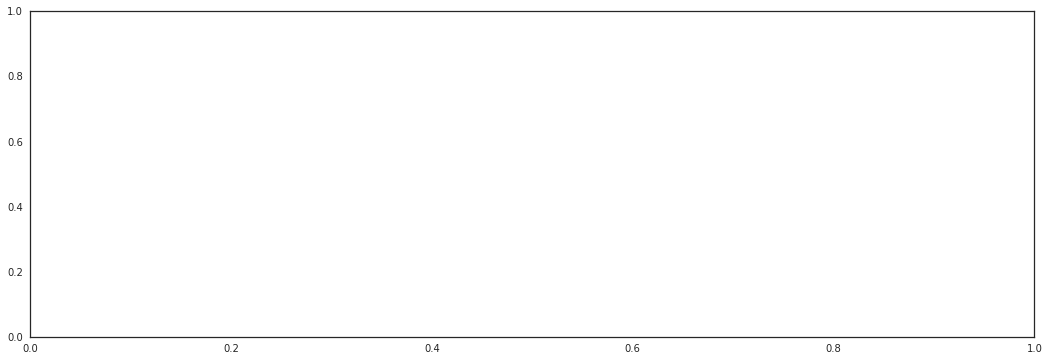

In [40]:
data = nTrain_df.groupby("datetime")["transactionRevenue"].agg(['count'])
line_plot(data)


- The number of transactions is up in December, likely in-line with Christmas
- There appears to be no increasing trend from the beginning of the dataset to the end
- Seasonality is apparent

In [ ]:
data = nTrain_df.groupby("datetime")["transactionRevenue"].agg(['size'])
line_plot(data)

- The number of visits is also up in November and December, preceding Christmas
- There is a similar spike in both plots, around May there is a sudden increase in visits and transactions

In [ ]:
data = nTest_df.groupby("datetime")["fullVisitorId"].agg(['size'])
line_plot(data)

- The test dataset shows a very large spike around December, much larger than any in the training dataset

## Data Preprocessing

- fill in missing revenue values as 0
- normalise data
- one hot encode data
- remove transactionRevenue from the dataset as a target variable
- split into training and validation data

- permutation importance
- SHAP


In [6]:
# sort by date for train-validation split
nTrain_df.sort_values(by=["datetime"], inplace=True)

# extract sorted dates
dates = pd.DataFrame(nTrain_df["date"])

# set target
target = pd.DataFrame(nTrain_df["transactionRevenue"])

# extract test IDs for later
test_ids = nTest_df["fullVisitorId"].values

# columns to be dropped before training the model
reduce_columns = ["bounces", "Unnamed: 0", "fullVisitorId", "date", "sessionId", "visitId", "visitStartTime", "isMobile", "city",
                 "metro", "networkDomain", "region", "adContent", "adwordsClickInfo.adNetworkType", 
                  "adwordsClickInfo.gclId", "adwordsClickInfo.isVideoAd", "adwordsClickInfo.page", 
                  "adwordsClickInfo.slot", "campaign", "isTrueDirect", "keyword", 
                  "medium", "referralPath", "source", "datetime"]

# drop columns from both datasets, including the two that are missing in the test dataset
train_features = nTrain_df.drop(reduce_columns + ["campaignCode", "transactionRevenue"], axis=1)

test = nTest_df.drop(reduce_columns, axis=1)


In [7]:
target.head()

,transactionRevenue
538448,0.0
538277,0.0
538278,0.0
538279,0.0
538280,0.0


In [7]:
# One-hot encode data
categorical_features = ["channelGrouping", "browser", "deviceCategory", "operatingSystem", 
                        "continent", "country", "subContinent"]
train_features = pd.get_dummies(train_features, columns=categorical_features)

test = pd.get_dummies(test, columns=categorical_features)

# Since the train and test datasets have different number of categories after one-hot encoding they need to be aligned
# an outer join includes all categories from both datasets
train_features, test = train_features.align(test, join='outer', axis=1)



In [8]:
# Replace NaN values throughout dataset
train_features.replace(to_replace=np.nan, value=0, inplace=True)
train_features.shape


(903653, 425)

In [9]:
# Replace NaN values throughout dataset
test.replace(to_replace=np.nan, value=0, inplace=True)
test.shape

(804684, 425)

In [10]:
# Log transform the labels in the target
target = np.log1p(target)
target.head()

,transactionRevenue
538448,0.0
538277,0.0
538278,0.0
538279,0.0
538280,0.0


In [11]:
# Normalise data
normalized_features = ["visitNumber",  "hits", "newVisits", "pageviews"]

scaler = preprocessing.MinMaxScaler()
train_features[normalized_features] = scaler.fit_transform(train_features[normalized_features])

test[normalized_features] = scaler.fit_transform(test[normalized_features])

##### Splitting the data into training and validation data for cross validation

Simply using the `train_test_split` method here is not suitable, since it randomly splits the data. This is normally acceptable as it prevents overfitting by introducing the power of randomness. Unfortunately as this is a time series, it is very possible that time-based trends are at play. Therefore a more appropriate way of splitting the data needs to be adopted.

The training dataset begins in 2016/08 and ends 2017/08, therefore is 12 months of data. 

Say I'd like to split this into 4 folds to be trained consecutively.

The below split will result in 4 folds which look something like this:

    run 1 : training [1], test [2]      50% of data is used
    run 2 : training [1 2], test [3]    75% of data is used
    run 3 : training [1 2 3], test [4] 100% of data is used
    
Each fold requires 4 lists: training features and targets, and validation features and targets


(Some inspiration taken from http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/)

In [12]:
def k_fold_split(X, y, dates, num_folds):
    
    k = int(np.floor(float(X.shape[0]) / num_folds))
    
    X_train_list = []
    y_train_list = []
    X_val_list = []
    y_val_list = []
    dates_list = []
        
    for i in range(2, num_folds + 1):
        
        # percentage split
        split = float(i-1)/i
        
        x_temp = X[:k*i]
        y_temp = y[:k*i]
        dates_list.append((dates.iloc[k*i]).values)
        
        # index to split current fold into train and test
        index = int(np.floor(x_temp.shape[0] * split))
        
        X_train = x_temp[:index]
        y_train = y_temp[:index]
        
        X_val = x_temp[index:]
        y_val = y_temp[index:]
        
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_val_list.append(X_val)
        y_val_list.append(y_val)
        
    return X_train_list, y_train_list, X_val_list, y_val_list, dates_list
        

In [36]:
X_train_list, y_train_list, X_val_list, y_val_list, dates_list = k_fold_split(train_features, target, dates, 5)

In [37]:
sets = [X_train_list, y_train_list, X_val_list, y_val_list, dates_list]

for i in sets:
    for x in i:
        print (x.shape)

(180730, 425)
(361460, 425)
(542190, 425)
(722920, 425)
(180730, 1)
(361460, 1)
(542190, 1)
(722920, 1)
(180730, 425)
(180730, 425)
(180730, 425)
(180730, 425)
(180730, 1)
(180730, 1)
(180730, 1)
(180730, 1)
(1,)
(1,)
(1,)
(1,)


## Baseline Model

In [17]:
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


In [47]:
new_dates = pd.DataFrame(dates_list)
new_dates['dates'] = new_dates[0].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
print (new_dates)

dates_long = pd.DataFrame(dates)
dates_long['date'] = dates_long['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
dates_long.shape

ValueError: invalid literal for int() with base 10: '2-01'

In [16]:
def performance_metric(predict, true):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """

    mse = mean_squared_error(predict, true)
    rmse = np.sqrt(mean_squared_error(predict, true))
    return mse, rmse

In [17]:
def train_predict(model, X_train, y_train, X_val, y_val):

    model = model.fit(X_train, y_train)

    val_predictions = model.predict(X_val)
    
    mse, rmse = performance_metric(val_predictions, y_val)
    
    return mse, rmse

    print('Validation MSE: %.2f' % mse)
    print('Validation RMSE: %.2f' % rmse)
    

In [21]:
model = DecisionTreeRegressor(random_state=42)

MSE = []
RMSE = []

for i in range(len(X_train_list)):
    X_train = X_train_list[i]
    y_train = y_train_list[i]
    X_val = X_val_list[i]
    y_val = y_val_list[i]
    
    mse, rmse = train_predict(model, X_train, y_train, X_val, y_val)
    MSE.append(mse)
    RMSE.append(rmse)


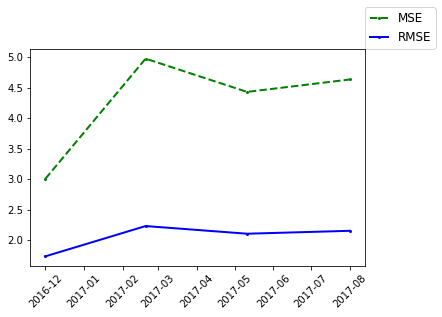

In [22]:
plt.plot(new_dates['dates'], MSE, 'go--', linewidth=2, markersize=2)
plt.plot(new_dates['dates'], RMSE, 'bo-', linewidth=2, markersize=2)
plt.legend(('MSE', 'RMSE'),
        loc=(1, 1), handlelength=1.5, fontsize=12)
plt.xticks(rotation=45)
plt.show()


Interestingly the model shows a sudden improvement in the second k-fold run, however there is a lot of volatility in the first few runs in the time series. This appears to flatten out somewhat when more data is used with the final 2 runs producing a RMSE of 2.16 and 2.14.

The average RMSE is 2.09

Now we can use this model to predict the outcome of the test set and create a submission file

In [23]:
predictions = model.predict(np.array(test))

submission = pd.DataFrame({"fullVisitorId":test_ids})
predictions[predictions<0] = 0
submission["PredictedLogRevenue"] = predictions
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"]
submission.to_csv("data/submission.csv", index=False)

In [46]:
print (submission.shape)
submission.head(10)

(617242, 2)


,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.0
1,0000049363351866189,0.0
2,0000053049821714864,0.0
3,0000059488412965267,0.0
4,0000085840370633780,0.0
5,0000091131414287111,0.0
6,0000117255350596610,0.0
7,0000118334805178127,0.0
8,0000130646294093000,0.0
9,0000150005271820273,0.0


In [ ]:
def shap_plot(model, X_val):
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)

    shap.summary_plot(shap_values, X_val)

In [ ]:
i = -1
X_train = X_train_list[i]
y_train = y_train_list[i]
X_val = X_val_list[i]
y_val = y_val_list[i]
model = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
shap_plot(model, X_val)

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. (https://github.com/slundberg/shap)

- high pageviews contribute to a higher totalRevenue according to the SHAP plot

In [ ]:
def feature_importance(model, X, y):
    perm = PermutationImportance(model, random_state=42).fit(X, y)
    return eli5.show_weights(perm, feature_names = X.columns.tolist())

In [ ]:
feature_importance(model, X_val, y_val)

The feature importance plot also places emphasis on pageviews but places being in the United States much lower, apparently not even in the top 20. Hits is ranked second, albeit with a much lower weight.

## Model Creation

- learning rate should decrease with time, takes smaller and smaller steps

In [18]:
def plot_metrics(loss, val_loss):
    fig, (ax1) = plt.subplots(1, 1, sharex='col', figsize=(20,7))
    ax1.plot(loss, label='Train loss')
    ax1.plot(val_loss, label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')
    plt.xlabel('Epochs')
    plt.show()

In [19]:
def plot_diff(X, diff):
    fig = plt.subplots(figsize=(18,6))
    plt.plot(diff, linewidth=1)
    plt.xticks(rotation=45)
    plt.show()

In [41]:
BATCH_SIZE = 64 # decrease if memory is not large enough
EPOCHS = 50
LEARNING_RATE = 1e-2 

In [21]:
# Sandbox model creation
model = Sequential()
model.add(Dense(426, kernel_initializer='glorot_normal', input_dim=X_train_list[0].shape[1]))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.4))
model.add(Dense(214, kernel_initializer='glorot_normal'))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.3))
model.add(Dense(108, kernel_initializer='glorot_normal'))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.2))
model.add(Dense(54, kernel_initializer='glorot_normal'))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(1))

#### Final model setup

In [42]:
model = Sequential()
model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train_list[0].shape[1]))
model.add(Dropout(0.4))
model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

In [20]:
# Setting a learning rate decay through the scheduler callback
# To be used in place of the decay rate in the optimizer
def schedule(epoch):
    print (LEARNING_RATE*(1/(epoch+1)))
    return LEARNING_RATE*(1/(epoch+1))
    


In [43]:
adam = optimizers.adam(lr=LEARNING_RATE, decay=0.001)
model.compile(loss='mse', optimizer=adam)

callback = [
  # Interrupt training if `val_loss` stops improving for so many epochs (patience) by an amount more than min_delta
  EarlyStopping(patience=4, monitor='val_loss', min_delta=0.0005),
  # Write TensorBoard logs to `./logs` directory
  TensorBoard(log_dir='./logs'),
  # Define a learning rate decay
#   LearningRateScheduler(schedule)
]

# To view Tensorboard 
# enter in command line  tensorboard --logdir='./logs/' and go to localhost:6006 in browser

Create additional callbacks

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               109056    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1040      
__________

#### Run the model over k iterations

In [3]:
x = [4,3,2]
y = [1,1,1]
difference = np.subtract(x, y)
print (difference)

[3 2 1]


Train on 180730 samples, validate on 180730 samples
Epoch 1/50
180730/180730 [==============================] - 18s - loss: 3.8082 - val_loss: 2.1052
Epoch 2/50
180730/180730 [==============================] - 18s - loss: 3.4522 - val_loss: 2.0635
Epoch 3/50
180730/180730 [==============================] - 18s - loss: 3.3755 - val_loss: 1.9911
Epoch 4/50
180730/180730 [==============================] - 18s - loss: 3.3306 - val_loss: 1.9514
Epoch 5/50
180730/180730 [==============================] - 18s - loss: 3.3022 - val_loss: 1.9622
Epoch 6/50
180730/180730 [==============================] - 18s - loss: 3.2822 - val_loss: 1.9646
Epoch 7/50
180730/180730 [==============================] - 18s - loss: 3.2598 - val_loss: 2.0154
Epoch 8/50
180730/180730 [==============================] - 18s - loss: 3.2624 - val_loss: 1.9928
Epoch 9/50
180730/180730 [==============================] - 18s - loss: 3.2519 - val_loss: 1.9889
180730
Model validation metrics
Run 1 of 4
MSE: 1.99
RMSE: 1.41


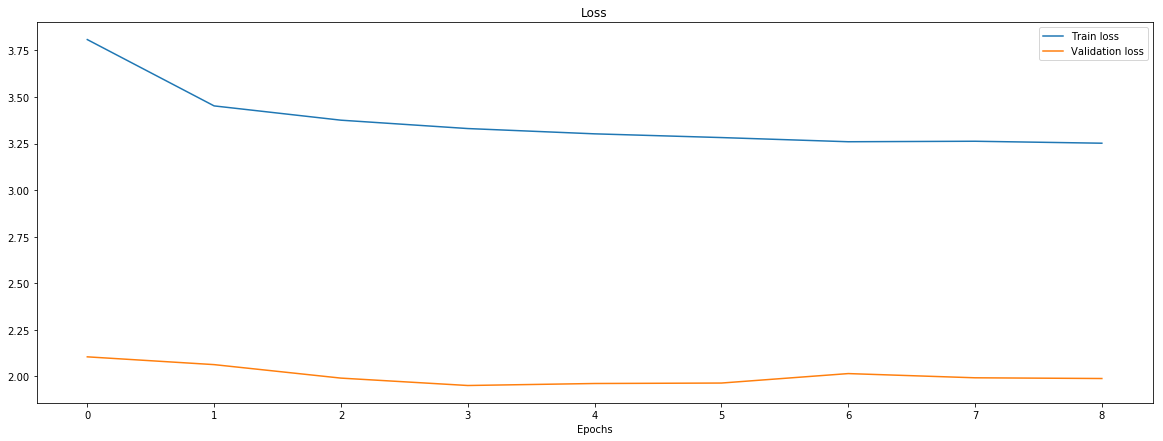

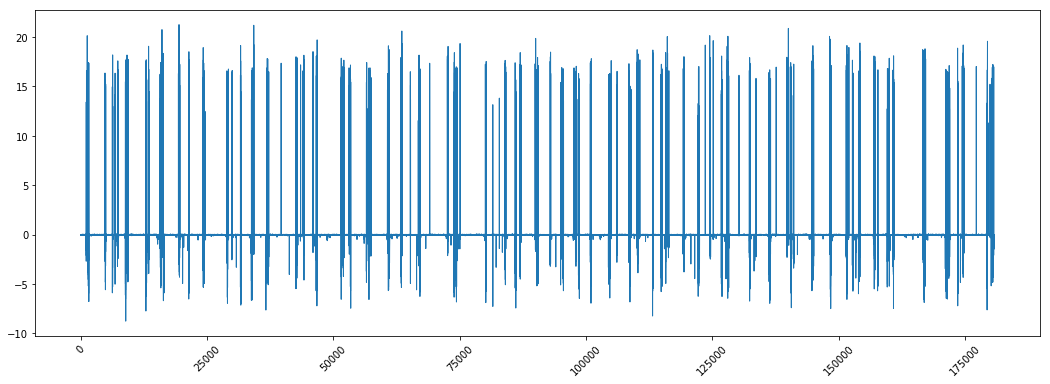

Train on 361460 samples, validate on 180730 samples
Epoch 1/50
361460/361460 [==============================] - 33s - loss: 2.5956 - val_loss: 3.3402
Epoch 2/50
361460/361460 [==============================] - 33s - loss: 2.5896 - val_loss: 3.2956
Epoch 3/50
361460/361460 [==============================] - 33s - loss: 2.5815 - val_loss: 3.2504
Epoch 4/50
361460/361460 [==============================] - 33s - loss: 2.5762 - val_loss: 3.2813
Epoch 5/50
361460/361460 [==============================] - 33s - loss: 2.5749 - val_loss: 3.2549
Epoch 6/50
361460/361460 [==============================] - 33s - loss: 2.5720 - val_loss: 3.3139
Epoch 7/50
361460/361460 [==============================] - 33s - loss: 2.5755 - val_loss: 3.2827
Epoch 8/50
361460/361460 [==============================] - 33s - loss: 2.5608 - val_loss: 3.2512
180730
Model validation metrics
Run 2 of 4
MSE: 3.25
RMSE: 1.80


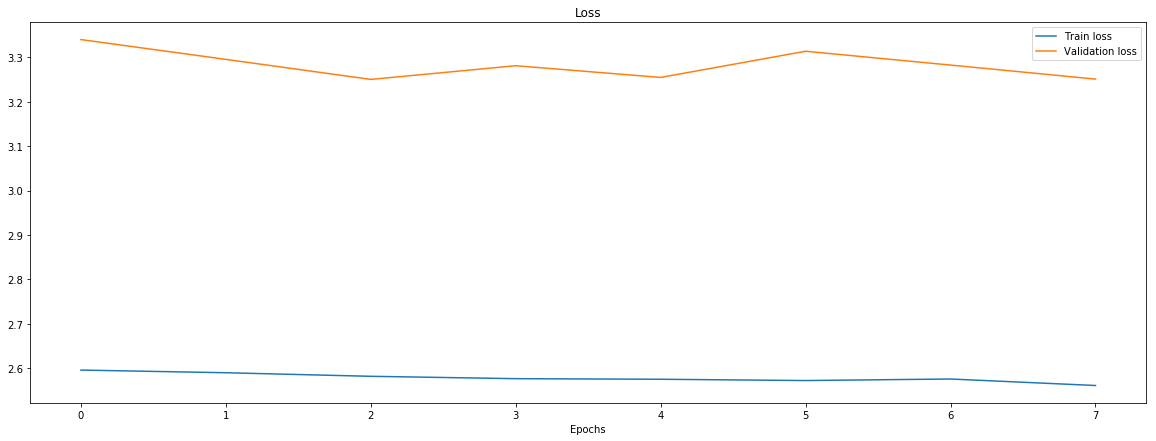

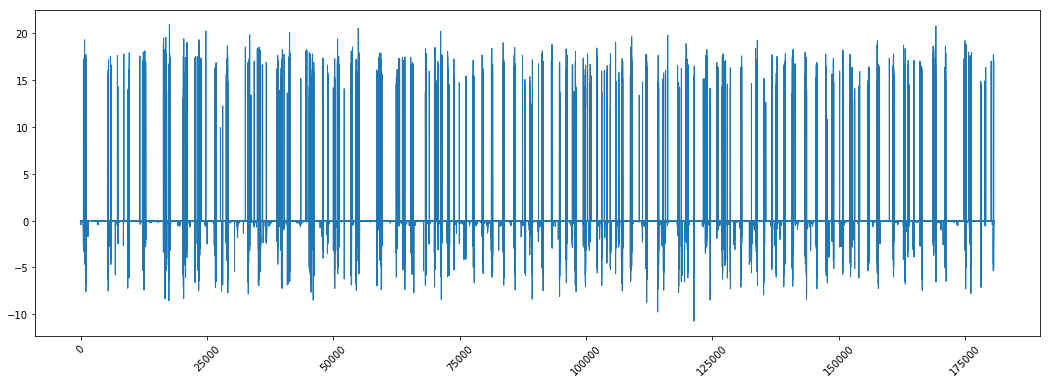

Train on 542190 samples, validate on 180730 samples
Epoch 1/50
542190/542190 [==============================] - 48s - loss: 2.7758 - val_loss: 3.2539
Epoch 2/50
542190/542190 [==============================] - 48s - loss: 2.7707 - val_loss: 3.2974
Epoch 3/50
542190/542190 [==============================] - 48s - loss: 2.7693 - val_loss: 3.2958
Epoch 4/50
542190/542190 [==============================] - 48s - loss: 2.7620 - val_loss: 3.2276
Epoch 5/50
542190/542190 [==============================] - 48s - loss: 2.7514 - val_loss: 3.2378
Epoch 6/50
542190/542190 [==============================] - 48s - loss: 2.7556 - val_loss: 3.2493
Epoch 7/50
542190/542190 [==============================] - 48s - loss: 2.7603 - val_loss: 3.2440
Epoch 8/50
542190/542190 [==============================] - 48s - loss: 2.7508 - val_loss: 3.2485
Epoch 9/50
542190/542190 [==============================] - 48s - loss: 2.7563 - val_loss: 3.2354
180730
Model validation metrics
Run 3 of 4
MSE: 3.24
RMSE: 1.80


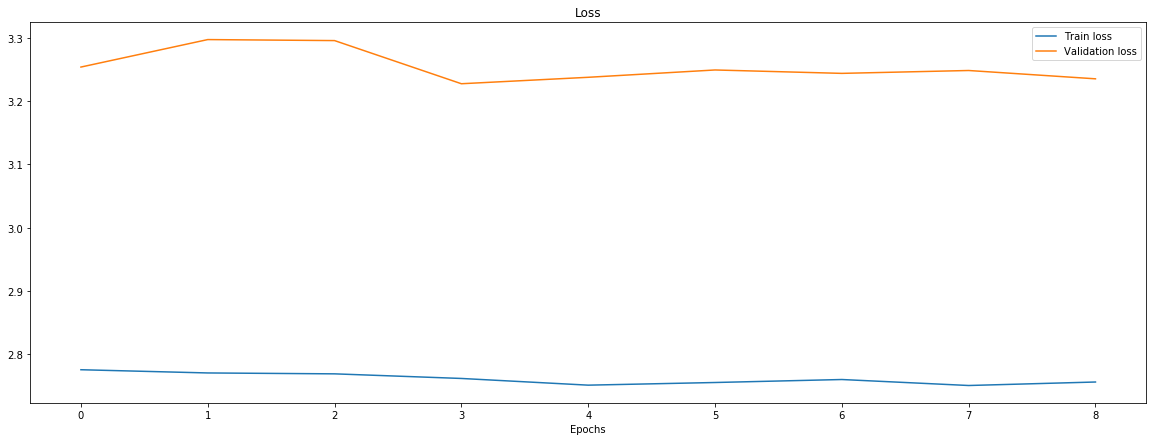

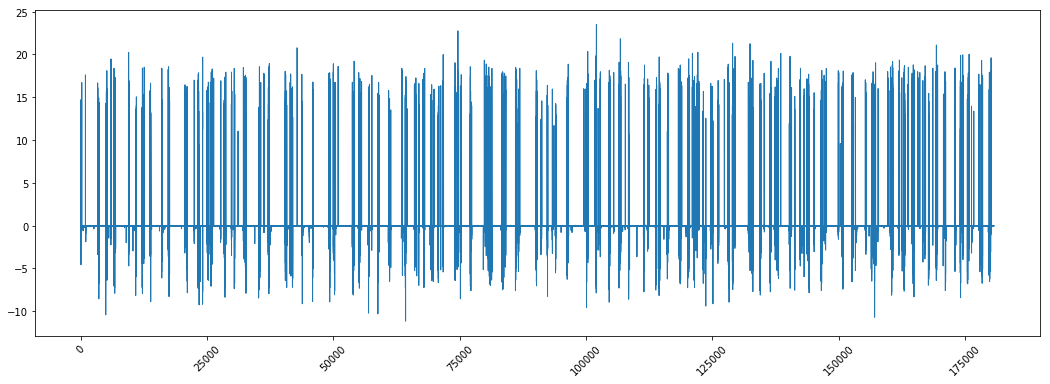

Train on 722920 samples, validate on 180730 samples
Epoch 1/50
722920/722920 [==============================] - 63s - loss: 2.8617 - val_loss: 3.2671
Epoch 2/50
722920/722920 [==============================] - 63s - loss: 2.8525 - val_loss: 3.2868
Epoch 3/50
722920/722920 [==============================] - 63s - loss: 2.8511 - val_loss: 3.2526
Epoch 4/50
722920/722920 [==============================] - 63s - loss: 2.8502 - val_loss: 3.2338
Epoch 5/50
722920/722920 [==============================] - 63s - loss: 2.8515 - val_loss: 3.2459
Epoch 6/50
722920/722920 [==============================] - 63s - loss: 2.8499 - val_loss: 3.2780
Epoch 7/50
722920/722920 [==============================] - 63s - loss: 2.8443 - val_loss: 3.2588
Epoch 8/50
722920/722920 [==============================] - 63s - loss: 2.8473 - val_loss: 3.2743
Epoch 9/50
722920/722920 [==============================] - 63s - loss: 2.8483 - val_loss: 3.2466
180730
Model validation metrics
Run 4 of 4
MSE: 3.25
RMSE: 1.80


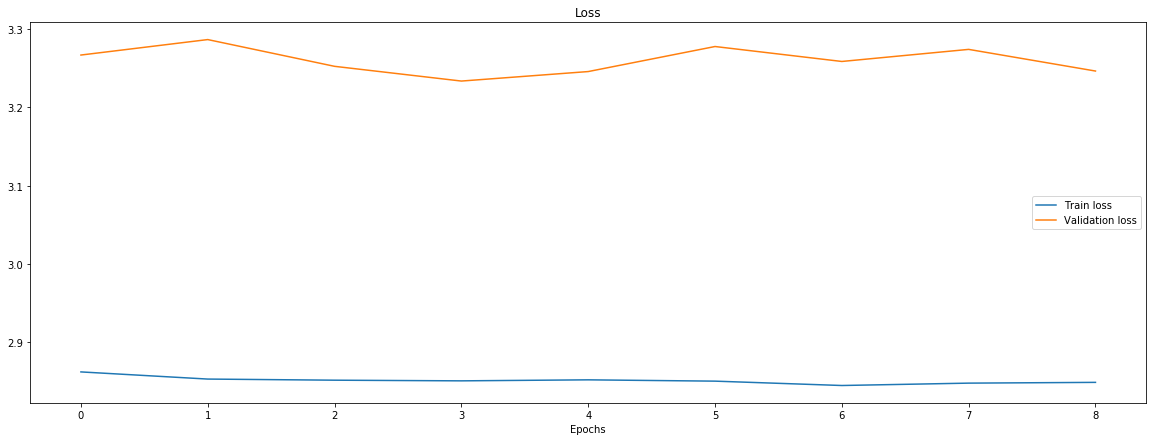

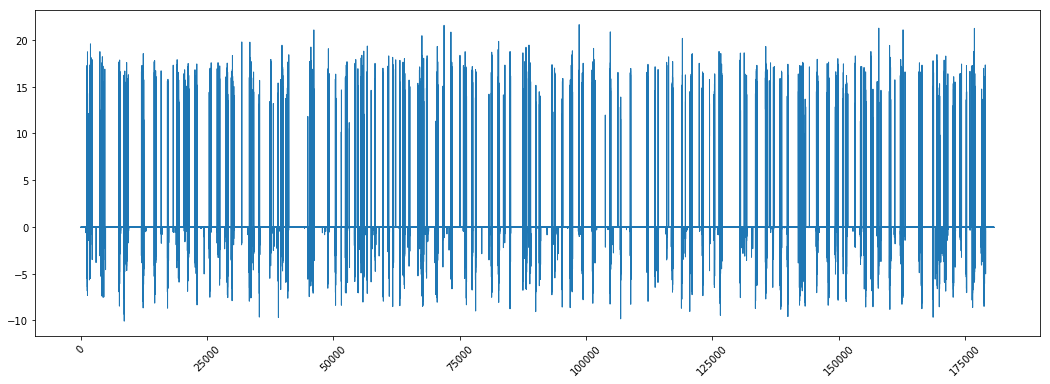

In [45]:
MSE = []
RMSE = []

for i in range(len(X_train_list)):
    X_train = np.array(X_train_list[i])
    y_train = np.array(y_train_list[i])
    X_val = np.array(X_val_list[i])
    y_val = np.array(y_val_list[i])
        
    history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, callbacks=callback, validation_data=(X_val, y_val))
    
    val_predictions = model.predict(X_val)
    mse, rmse = performance_metric(val_predictions, y_val)
    MSE.append(mse)
    RMSE.append(rmse)
    
    difference = np.subtract(y_val, val_predictions)

    print('Model validation metrics')
    print ('Run {} of {}'.format(i+1, len(X_train_list)))
    print('MSE: %.2f' % mse)
    print('RMSE: %.2f' % rmse)
    plot_metrics(history.history['loss'], history.history['val_loss'])
    plot_diff(X_train, difference)



In [1]:
plt.plot(new_dates['dates'], MSE, 'go--', linewidth=2, markersize=2)
plt.plot(new_dates['dates'], RMSE, 'bo-', linewidth=2, markersize=2)
plt.legend(('MSE', 'RMSE'),
        loc=(1, 1), handlelength=1.5, fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [48]:
predictions = model.predict(np.array(test))

submission = pd.DataFrame({"fullVisitorId":test_ids})
# submission = submission[:20000]
predictions[predictions<0] = 0
submission["PredictedLogRevenue"] = predictions
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"]
submission.to_csv("data/submission.csv", index=False)

Shape of submission should be (617242, 2)

In [49]:
print (submission.shape)
submission.head(10)

(617242, 2)


,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,1.427895
1,0000049363351866189,0.035681
2,0000053049821714864,0.001116
3,0000059488412965267,0.129946
4,0000085840370633780,0.043987
5,0000091131414287111,0.008205
6,0000117255350596610,4.033306
7,0000118334805178127,0.016495
8,0000130646294093000,0.017325
9,0000150005271820273,0.021865


### Save model

Save the entire state of the model for later reference

In [30]:
model.save('models/model_11.h5')

Load a previously used model:
- model_1.h5 = RMSE val= 1.75, test= 1.7894
    - dense layers: 5 (first layer 256 nodes then halved)
    - activation: relu
    - dropout: none
    - batch size: 64
    - learning rate: 0.01
    - epochs: 10
    
- model_2.h5 = RMSE val= 1.70, test=1.7025
    - dense layers: 5 
    - activation: relu
    - dropout: 0.4, 0.3, 0.2
    - batch size: 64
    - learning rate: 0.0001
    - epochs: 100
    - early stop patience: 5
    
- model_3.h5 = RMSE val= , test= 1.5143
    - dense layers: 5 
    - activation: relu
    - dropout: 0.4, 0.3, 0.2
    - batch size: 64
    - initial learning rate: 0.01
    - epochs: 100
    - early stop patience: 3
    - decay: 0.1
    
- model_4.h5 = RMSE val= 1.8, test= 1.5324
    - dense layers: 5 
    - activation: tanh
    - dropout: 0.4, 0.3, 0.2
    - batch size: 64
    - initial learning rate: 0.1
    - epochs: 50
    - early stop patience: 3
    - decay: 0.1
    
- model_5.h5 = RMSE val= 2.1, test= 1.7493
    - dense layers: 5 (first layer 426 nodes then halved)
    - activation: relu
    - dropout: 0.4, 0.3, 0.2
    - batch size: 64
    - initial learning rate: 0.1
    - epochs: 50
    - early stop patience: 3
    - decay: 0.1
    
- model_6.h5 = RMSE val= 1.78, test= 1.5128
    - dense layers: 5 (first layer 426 nodes then halved)
    - activation: relu
    - dropout: 0.4, 0.3, 0.2
    - batch size: 64
    - initial learning rate: 0.001
    - epochs: 50
    - early stop patience: 3
    - decay: 0.1
    
- model_7.h5 = RMSE val= 1.74, test= 1.5332
    - dense layers: 5 (first layer 426 nodes then halved)
    - activation: relu
    - dropout: 0.5, 0.5, 0.5
    - batch size: 64
    - initial learning rate: 0.001
    - epochs: 50
    - early stop patience: 3
    - decay: LearningRateScheduler (LR*(1/(EPOCH+1)))
    
- model_8.h5 = RMSE val= 1.73, test= 1.5169
    - dense layers: 5 (first layer 426 nodes then halved)
    - activation: Leaky relu (alpha =0.1
    - dropout: 0.4, 0.3, 0.2
    - batch size: 64
    - initial learning rate: 0.001
    - epochs: 50
    - early stop patience: 3
    - decay: LearningRateScheduler (LR*(1/(EPOCH+1)))
    
- model_9.h5 (model 3 replica w/ 5 k-folds) = RMSE val= 1.86 , test= 1.5093
    - dense layers: 5 
    - activation: relu
    - dropout: 0.4, 0.3, 0.2
    - batch size: 64
    - initial learning rate: 0.001
    - epochs: 50
    - early stop patience: 3
    - decay: 0.01
    
- model_10.h5  = RMSE val= 1.84 , test= 1.5098
    - k-folds: 5
    - dense layers: 5 
    - activation: relu
    - dropout: 0.4, 0.3, 0.2
    - batch size: 128
    - initial learning rate: 0.001
    - epochs: 50
    - early stop patience: 3
    - decay: 0.01
- model_11.h5  = RMSE val= 1.88 , test= 1.5121
    - k-folds: 15
    - dense layers: 5 
    - activation: relu
    - dropout: 0.4, 0.3, 0.2
    - batch size: 64
    - initial learning rate: 0.001
    - epochs: 50
    - early stop patience: 3
    - min delta: 0.0005
    - decay: 0.01
- model_12.h5  = RMSE val= 1.80 , test= 1.5006
    - k-folds: 5
    - dense layers: 5 
    - activation: relu
    - dropout: 0.4, 0.3, 0.2
    - batch size: 64
    - initial learning rate: 0.01
    - epochs: 50
    - early stop patience: 4
    - min delta: 0.0005
    - decay: 0.001

#### Results ####

**Model**      | **Validation RMSE** | **Test RMSE**
---------------|---------------------|-----------
Baseline DTR    |       2.14         |  1.9443
Baseline DTR (5 k) |    -            | 1.9615
Baseline zeroes |        -           |  1.7804
Baseline DNN    |        -           |  1.82
Baseline LGBM   |       -            |  1.70
Model 1         |       1.75         | 1.7894
Model 2         |       1.86         | 1.7025
Model 3         |       1.69         | 1.5143
Model 4         |       1.80         | 1.5324
Model 5         |       2.10         | 1.7493
Model 6         |       1.78         | 1.5128
Model 7         |       1.74         | 1.5332
Model 8         |       1.73         | 1.5169
Model 9         |       1.86         | **1.5093**
Model 10        |       1.84         | 1.5098
Model 11        |       1.88         | 1.5121
Model 12        |       1.80         | 1.5006

### Reload old model

In [31]:
model = models.load_model('models/model_9.h5')

### Additional formula
Find the optimal learning rate range

 References
 
    Blog post: jeremyjordan.me/nn-learning-rate
    
    Original paper: https://arxiv.org/abs/1506.01186

In [68]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        

    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')